In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
# Get Data

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [5]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [6]:
fname = '09/frame_00667_rgb.jpg'

In [7]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

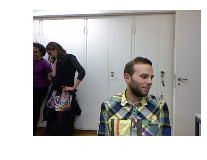

In [8]:
img = open_image(path/fname)
img.show()

In [9]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [10]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2, c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img, pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [11]:
get_ctr(fname)

tensor([263.9104, 428.5814])

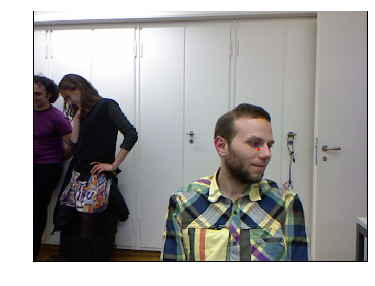

In [12]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6,6))

Creating Dataset

In [13]:
bs = 64

In [13]:
data = (PointsItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name=='13')
       .label_from_func(get_ctr)
       .transform(get_transforms(), tfm_y=True, size=(120,160))
       .databunch(bs=bs).normalize(imagenet_stats)
       )

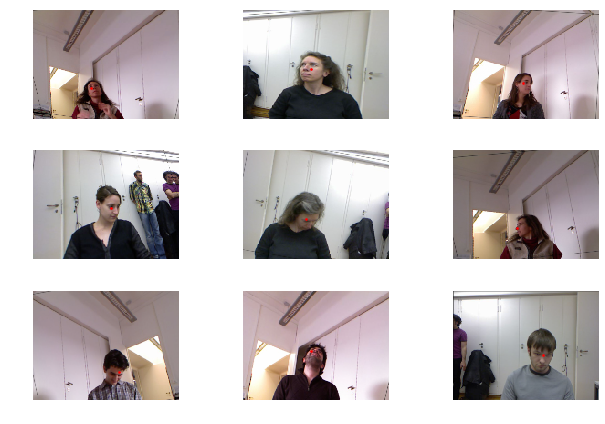

In [16]:
data.show_batch(3, figsize=(9, 6))

### Train Model

In [17]:
learn = cnn_learner(data, models.resnet34).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


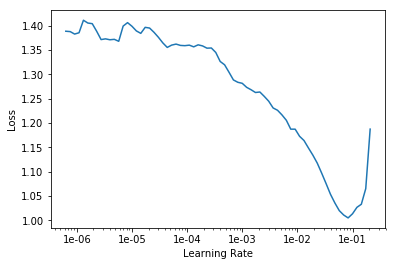

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
lr = 2e-2

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.049621,0.014329,02:36
1,0.018078,0.004136,02:31
2,0.008311,0.000995,02:33
3,0.005061,0.000924,02:29
4,0.003781,0.000369,02:31


In [21]:
learn.save('stage-1')

In [22]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (15193 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/jupyter/.fastai/data/biwi_head_pose;

Valid: LabelList (485 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/jupyter/.fastai/data/biwi_head_pose;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dila

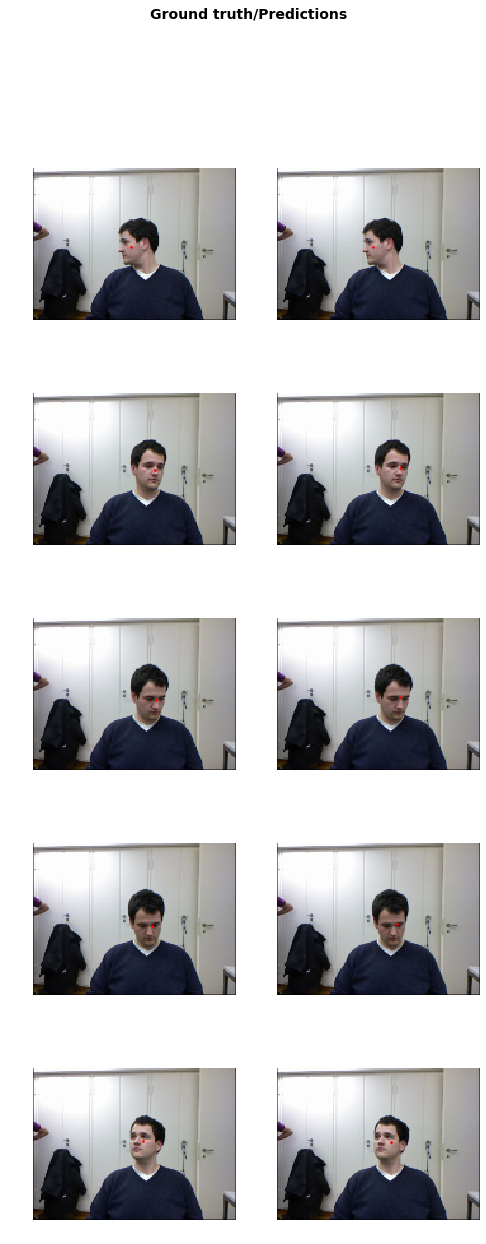

In [23]:
learn.show_results()

### Data Augmentation

In [14]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name=='13')
       .label_from_func(get_ctr)
       .transform(get_transforms(), tfm_y=True, size=(120,160))
       .databunch(bs=bs).normalize(imagenet_stats)
       )

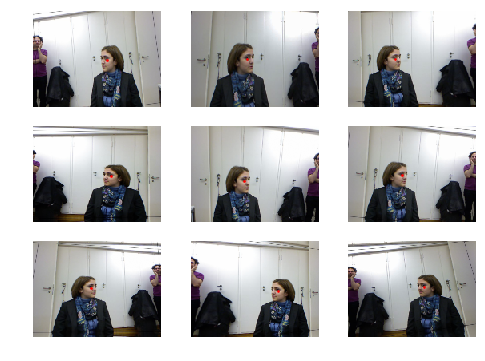

In [15]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8,6))